In [55]:
import numpy as np
import random

In [ ]:
class Node:

    def __init__(self, data, labels):
        self.index = None  # индекс признака, по которому ведётся сравнение с порогом в этом узле
        self.t = None  # значение порога
        self.true_branch = None  # поддерево, удовлетворяющее условию в узле
        self.false_branch = None  # поддерево, не удовлетворяющее условию в узле
        self.data = data
        self.labels = labels

    # Расчёт критерия Джини
    @staticmethod
    def gini(labels):
        _, counts = np.unique(labels, return_counts=True)
        n = len(labels)
        return np.dot(counts / n, 1 - counts / n)

    # Расчёт качества
    def quality(self, true_labels, false_labels):
        X_r = len(true_labels)
        X_l = len(false_labels)
        return (Node.gini(self.labels) - 
                X_r / len(self.labels) * Node.gini(true_labels) - 
                X_l / len(self.labels) * Node.gini(false_labels))

    def split(self, index, t):
        true_mask = self.data[:, index] >= t
        false_mask = ~true_mask

        true_data = self.data[true_mask]
        false_data = self.data[false_mask]
        true_labels = self.labels[true_mask]
        false_labels = self.labels[false_mask]
        return true_data, false_data, true_labels, false_labels

    def get_subsample(self):
        # будем сохранять не сами признаки, а их индексы
        sample_indexes = [i for i in range(self.data.shape[1])]

        len_subsample = int(np.sqrt(self.data.shape[1]))
        subsample = []

        random.shuffle(sample_indexes)
        for _ in range(len_subsample):
            subsample.append(sample_indexes.pop())

        return subsample

    # Нахождение наилучшего разбиения
    def find_best_split(self, min_leaf, max_depth):
        n_values, n_features = self.data.shape
        if len(np.unique(self.labels)) == 1 or n_values < min_leaf or max_depth == 0:
            return
        best_quality = 0

        for index in self.get_subsample():
            for t in np.unique(self.data[:, index]):
                _, _, true_labels, false_labels = self.split(index, t)
                cur_quality = self.quality(true_labels, false_labels)
                if cur_quality > best_quality:
                    best_quality = cur_quality
                    self.index = index
                    self.t = t
        
        true_data, false_data, true_labels, false_labels = self.split(self.index, self.t)
        self.true_branch = Node(true_data, true_labels)
        self.true_branch.find_best_split(min_leaf, max_depth - 1)
        self.false_branch = Node(false_data, false_labels)
        self.false_branch.find_best_split(min_leaf, max_depth - 1)

    
    def classify_obj(self, obj):
        if self.index is None:
            values, counts = np.unique(self.labels, return_counts=True)
            return values[np.argmax(counts)]
        if obj[self.index] >= self.t:
            return self.true_branch.classify_obj(obj)
        else:
            return self.false_branch.classify_obj(obj)


In [57]:
class DecisionTree:

    def __init__(self, min_leaf=5, max_depth=-1):
        self.root = None
        self.min_leaf = min_leaf
        self.max_depth = max_depth

    def build_tree(self, data, labels):
        self.root = Node(data, labels)
        self.root.find_best_split(self.min_leaf, self.max_depth)

    # Проход объекта по дереву для его классификации
    def classify_obj(self, obj):
        return self.root.classify_obj(obj)

    # Предсказание деревом для всего датасета
    def predict(self, data):
        return np.array([self.classify_obj(row) for row in data])


In [58]:
class RandomForest:

    def __init__(self, num_of_trees, min_leaf=1, max_depth=-1):
       self.trees = []
       self.num_of_trees = num_of_trees
       self.min_leaf = min_leaf
       self.max_depth = max_depth

    @staticmethod
    def get_bootstrap(data, labels, N):
        n_samples = data.shape[0]
        bootstrap = []

        for _ in range(N):
            rng = np.random.default_rng()
            idx = rng.integers(0, high=n_samples, size=n_samples)
            b_data = data[idx]
            b_labels = labels[idx]

            bootstrap.append((b_data, b_labels))

        return bootstrap

    def fit(self, data, labels):
        bootstrap = self.get_bootstrap(data, labels, self.num_of_trees)
        for i in range(self.num_of_trees):
            tree = DecisionTree(min_leaf=self.min_leaf, max_depth=self.max_depth)
            tree.build_tree(bootstrap[i][0], bootstrap[i][1])
            self.trees.append(tree)
    
    def tree_vote(self, data):
        predictions = np.array([tree.predict(data) for tree in self.trees]).T
        from scipy import stats
        voted_predictions = stats.mode(predictions, axis=1).mode.flatten()
        return voted_predictions
            

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

# Генерация нелинейных данных для классификации
np.random.seed(42)

# Класс 0: Внутренний круг
n_samples_0 = 200
theta = np.random.uniform(0, 2*np.pi, n_samples_0)
r = np.random.uniform(0, 2, n_samples_0)
X0_inner = np.column_stack([r * np.cos(theta), r * np.sin(theta)]) + [0, 0]
y0_inner = np.zeros(n_samples_0)

# Класс 0: Диагональная полоса
n_samples_0_diag = 200
x_diag = np.random.uniform(-4, 4, n_samples_0_diag)
y_diag = x_diag + np.random.normal(0, 0.5, n_samples_0_diag)
X0_diag = np.column_stack([x_diag, y_diag])
y0_diag = np.zeros(n_samples_0_diag)

# Класс 1: Противоположная диагональная полоса
n_samples_1_diag = 400
x_diag = np.random.uniform(-4, 4, n_samples_1_diag)
y_diag = -x_diag + np.random.normal(0, 0.5, n_samples_1_diag)
X1_diag = np.column_stack([x_diag, y_diag])
y1_diag = np.ones(n_samples_1_diag)

# Объединяем все данные
X = np.vstack([X0_inner, X0_diag, X1_diag])
y = np.hstack([y0_inner, y0_diag, y1_diag])

# Перемешиваем данные
shuffle_idx = np.random.permutation(len(X))
X = X[shuffle_idx]
y = y[shuffle_idx]

# Разделяем на обучающую и тестовую выборки
split_idx = int(0.8 * len(X))
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

print(f"Размеры данных:")
print(f"Всего: {len(X)} samples")
print(f"Обучающая выборка: {len(X_train)} samples")
print(f"Тестовая выборка: {len(X_test)} samples")
print(f"Баланс классов: {np.bincount(y.astype(int))}")

Размеры данных:
Всего: 800 samples
Обучающая выборка: 640 samples
Тестовая выборка: 160 samples
Баланс классов: [400 400]


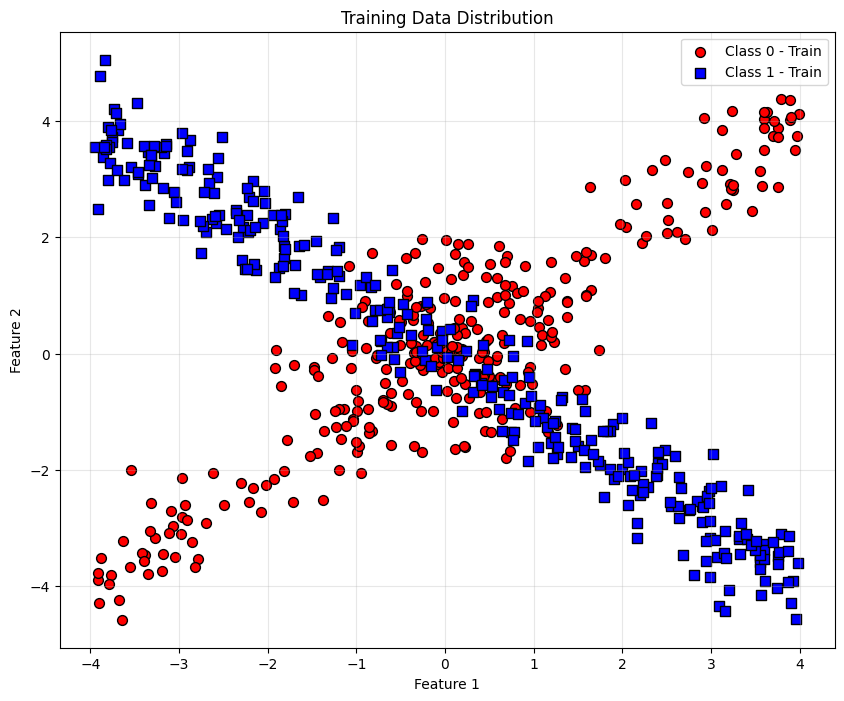

0.88125


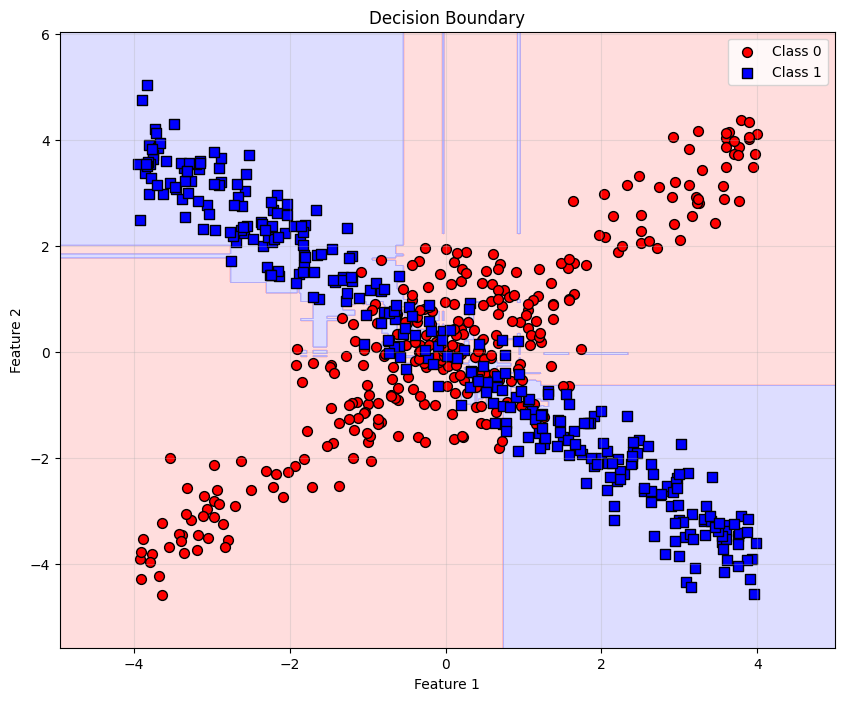

In [60]:
from sklearn.metrics import accuracy_score

def plot_decision_boundary(forest, X, y, title="Decision Boundary"):
    """Визуализация данных и границы решений"""
    h = 0.02  # шаг сетки
    
    # Определяем границы для сетки
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Создаем сетку
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Предсказываем для всех точек сетки
    Z = forest.tree_vote(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Создаем график
    plt.figure(figsize=(10, 8))
    
    # Отображаем границу решений
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=ListedColormap(['#FFAAAA', '#AAAAFF']))
    
    # Отображаем обучающие точки
    plt.scatter(X[y == 0, 0], X[y == 0, 1], 
                c='red', marker='o', edgecolors='k', s=50, label='Class 0')
    plt.scatter(X[y == 1, 0], X[y == 1, 1], 
                c='blue', marker='s', edgecolors='k', s=50, label='Class 1')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

# Визуализируем обучающие данные
plt.figure(figsize=(10, 8))
plt.scatter(X_train[y_train == 0, 0], X_train[y_train == 0, 1], 
            c='red', marker='o', edgecolors='k', s=50, label='Class 0 - Train')
plt.scatter(X_train[y_train == 1, 0], X_train[y_train == 1, 1], 
            c='blue', marker='s', edgecolors='k', s=50, label='Class 1 - Train')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Training Data Distribution')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

forest = RandomForest(num_of_trees=5)
forest.fit(X_train, y_train)
y_pred2 = forest.tree_vote(X_test)
print(accuracy_score(y_test, y_pred2))
plot_decision_boundary(forest, X_train, y_train)